# XGBOOST

### Import Libraries

In [158]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import auc
from matplotlib import pyplot as plt

%matplotlib inline


pd.set_option('display.max_columns', None)

### Import Dataset

In [159]:
df = pd.read_csv("../EDA/cleaned_df_2017-05-28.csv",  parse_dates=['timestamp'], index_col=False, low_memory=False)
build_state_df = pd.read_csv("../EDA/merged_w_state_build_year_2017-05-28.csv",  parse_dates=['timestamp'], index_col=False, low_memory=False)
train_df = pd.read_csv("../Sberbank/train.csv",  parse_dates=['timestamp'], index_col=False, low_memory=False)
test_df = pd.read_csv("../Sberbank/test.csv",  parse_dates=['timestamp'], index_col=False, low_memory=False)

frames = [train_df, test_df]

price_doc_df = pd.concat(frames)

df = df.merge(build_state_df[['id','age','state']], how='left', on='id', suffixes=('','_imputed'))
df = df.merge(price_doc_df[['id','price_doc']], how='left', on='id', suffixes=('','_orig'))

In [160]:
df['price_doc'] = df['price_doc_orig']

df = df.drop('price_doc_orig', axis=1)

In [161]:
df['price_doc_log'] = np.log1p(df['price_doc'])

In [162]:
df.set_index()

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            38113, 38114, 38115, 38116, 38117, 38118, 38119, 38120, 38121,
            38122],
           dtype='int64', length=38123)

### Select Features

In [1]:
features = ['timestamp', 'floor', 'full_sqrt', 'area_km', 'density','month','year','day',
                'rel_floor', 'material', 'age_imputed', 'num_room', 'work_share','kitch_sq',
                'state_imputed', 'product_type', 'sub_area', 'indust_part', 'sport_objects_raion', 'oil_chemistry_raion', 'metro_min_avto',
               'green_zone_km', 'industrial_km', 'kremlin_km', 'radiation_km', 'ts_km', 'fitness_km',
               'stadium_km', 'park_km', 'price_doc_log']

In [153]:
for feature in features:
    if np.sum(df[feature].isnull()) > 0:
        print feature,np.sum(df[feature].isnull())

KeyError: 'timestamp'

In [154]:
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

[imp.fit_transform(df[feature].values) for feature in df[features].columns]

KeyError: "['timestamp'] not in index"

In [155]:
msno.matrix(df[features])

KeyError: "['timestamp'] not in index"

In [156]:
# df = df.select_dtypes(exclude=['datetime'])
df = df[features]

y_train = df.loc[df['price_doc_log'].notnull(), 'price_doc_log']
X_train = df.loc[df['price_doc_log'].notnull(), df.columns != 'price_doc_log']
X_test = df.loc[df['price_doc_log'].isnull(), df.columns != 'price_doc_log']

print y_train.shape, X_train.shape, X_test.shape

KeyError: "['timestamp'] not in index"

## Selecting Features

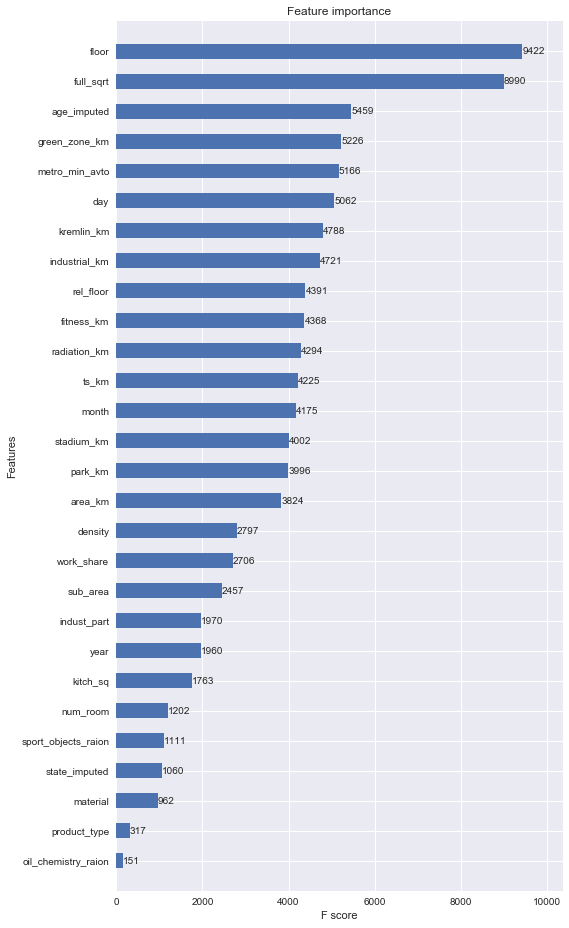

In [148]:
import xgboost as xgb

xgb_params = {
    'eta': 0.02,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)


# Uncomment to tune XGB `num_boost_rounds`

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

# num_boost_round = 427

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, height=0.5, ax=ax)

y_pred = model.predict(dtest)

In [149]:
y_test = np.expm1(y_pred)

In [151]:
y_test_no_ts = y_test

In [163]:
sample = pd.read_csv('../sample_submission.csv', index_col=False)

sample.head(10)

,id,price_doc
0,30474,7118500.41
1,30475,7118500.41
2,30476,7118500.41
3,30477,7118500.41
4,30478,7118500.41
5,30479,7118500.41
6,30480,7118500.41
7,30481,7118500.41
8,30482,7118500.41
9,30483,7118500.41


In [164]:
sample['price_doc'] = y_test_no_ts

In [167]:
sample.to_csv('./xgboost_w_clean_052717.csv', index=False)